# Day 5: Hydrothermal Venture

You come across a field of hydrothermal vents on the ocean floor! These vents constantly produce large, opaque clouds, so it would be best to avoid them if possible.

They tend to form in lines; the submarine helpfully produces a list of nearby lines of vents (your puzzle input) for you to review. For example:

```
0,9 -> 5,9
8,0 -> 0,8
9,4 -> 3,4
2,2 -> 2,1
7,0 -> 7,4
6,4 -> 2,0
0,9 -> 2,9
3,4 -> 1,4
0,0 -> 8,8
5,5 -> 8,2
```

Each line of vents is given as a line segment in the format x1,y1 -> x2,y2 where x1,y1 are the coordinates of one end the line segment and x2,y2 are the coordinates of the other end. These line segments include the points at both ends. In other words:

- An entry like 1,1 -> 1,3 covers points 1,1, 1,2, and 1,3.
- An entry like 9,7 -> 7,7 covers points 9,7, 8,7, and 7,7.

For now, only consider horizontal and vertical lines: lines where either x1 = x2 or y1 = y2.

So, the horizontal and vertical lines from the above list would produce the following diagram:

```
.......1..
..1....1..
..1....1..
.......1..
.112111211
..........
..........
..........
..........
222111....
```

In this diagram, the top left corner is 0,0 and the bottom right corner is 9,9. Each position is shown as the number of lines which cover that point or . if no line covers that point. The top-left pair of 1s, for example, comes from 2,2 -> 2,1; the very bottom row is formed by the overlapping lines 0,9 -> 5,9 and 0,9 -> 2,9.

To avoid the most dangerous areas, you need to determine the number of points where at least two lines overlap. In the above example, this is anywhere in the diagram with a 2 or larger - a total of 5 points.

Consider only horizontal and vertical lines. At how many points do at least two lines overlap?

In [1]:
import matplotlib.pyplot as plt
from typing import List, Union, Tuple
import numpy as np

In [2]:
with open('../data/day_05_puzzle_1', 'r') as f:
    data = f.readlines()

In [3]:
def vent_parser(input: List[str]) -> np.array:
    coordinates = []
    for line in input:
        tmp = line.split('->')
        coords = [ [int(xy.strip()) for xy in c.split(',')] for c in tmp]
        coordinates.append(coords)
    return np.array(coordinates)

In [4]:
coords = vent_parser(data)

In [5]:
def compare_with_raw_input(input: np.array, raw: List[str] = None) -> Union[List[str], bool]:
    reconstruction = []
    for coord in input:
        xy1 = str(coord[0][0]) + ',' + str(coord[0][1])
        xy2 = str(coord[1][0]) + ',' + str(coord[1][1])
        reconstruction.append(xy1 + ' -> ' + xy2 + '\n')
    if raw:
        return reconstruction == raw
    else:
        return reconstruction
        

sanity tests that we read the data right...

In [6]:
assert compare_with_raw_input(coords, data)

In [7]:
assert coords[-1].shape == (2,2)

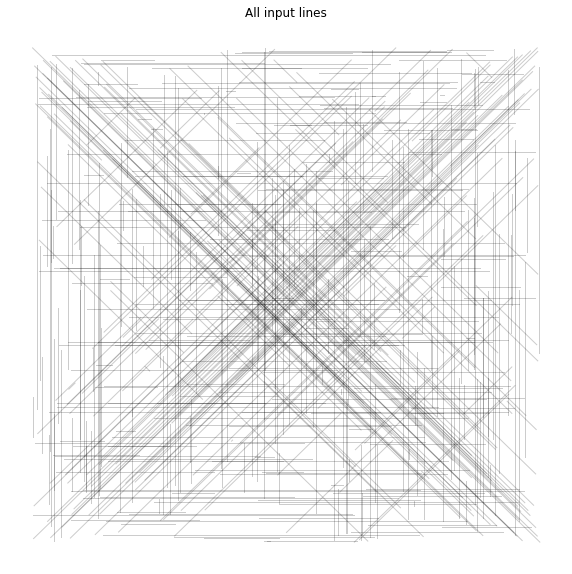

In [8]:
plt.figure(figsize=[10,10])
for line in coords:
    plt.plot(line[:,0], line[:,1], color='black', alpha=0.2, linewidth=1)
plt.title('All input lines')
plt.axis(False)
plt.show()

calculate display dimensions, aka min and max of each line

In [9]:
xmax = np.concatenate((coords[:,0][:,0], coords[:,1][:,0])).max()
ymax = np.concatenate((coords[:,0][:,1], coords[:,1][:,1])).max()
xmin = np.concatenate((coords[:,0][:,0], coords[:,1][:,0])).min()
ymin = np.concatenate((coords[:,0][:,1], coords[:,1][:,1])).min()

In [10]:
print('display min resolution x-y:', xmin, ymin)
print('display max resolution x-y:', xmax, ymax)

display min resolution x-y: 10 10
display max resolution x-y: 989 989


In [11]:
def diagonal(xy1: Union[list, np.array], xy2: Union[list, np.array]) -> Tuple[np.array]:
    """Calculate the diagonal coordinates from point xy1 to point xy2.
    This function only calculates diagonals with 45 degrees angles.

    Args:
        xy1 (Union[list, np.array]): Starting point
        xy2 (Union[list, np.array]): Target point

    Raises:
        ValueError: In case of non-45 degree lines and in case of wrong or malformed input.

    Returns:
        Tuple[np.array]: The x,y coordinates of all the points along the line
    """
    # we're using 4 cases derived from the 4 quartiles of the cartesian plane
    # xy1 is our origin
    # xy2 is our target
    if (xy1[0] <= xy2[0]) and (xy1[1] <= xy2[1]):
        # 1st quarter
        x = np.arange(xy1[0], xy2[0] + 1)
        y = np.arange(xy1[1], xy2[1] + 1)
    elif (xy1[0] >= xy2[0]) and (xy1[1] <= xy2[1]):
        # 2nd quarter
        x = np.flip(np.arange(xy2[0], xy1[0] + 1))
        y = np.arange(xy1[1], xy2[1] + 1)
    elif (xy1[0] >= xy2[0]) and (xy1[1] >= xy2[1]):
        # 3rd quarter
        x = np.flip(np.arange(xy2[0], xy1[0] + 1))
        y = np.flip(np.arange(xy2[1], xy1[1] + 1))
    elif (xy1[0] <= xy2[0]) and (xy1[1] >= xy2[1]):
        # 4th quarter
        x = np.arange(xy1[0], xy2[0] + 1)
        y = np.flip(np.arange(xy2[1], xy1[1] + 1))
    else:
        raise ValueError(f"Looks there's something off with the xy1: {xy1} and xy2: {xy2}")

    if len(x) != len(y):
        raise ValueError(f"The line between xy1: {xy1} and xy2: {xy2} is not 45 degrees.")

    return x, y

In [12]:
t_map = {'vertical': 0,
         'horizontal': 1,
         'diagonal': 2
}
lines = []
for xy in coords:
    if xy[0][0] == xy[1][0]:
        y_sorted = sorted([xy[0][1], xy[1][1]])
        y = np.arange(start=y_sorted[0], stop=y_sorted[1] + 1, step=1)
        x = [xy[0][0]] * y.shape[0]
        t = [0] * y.shape[0]
    elif xy[0][1] == xy[1][1]:
        x_sorted = sorted([xy[0][0], xy[1][0]])
        x = np.arange(start=x_sorted[0], stop=x_sorted[1] + 1, step=1)
        y = [xy[0][1]] * x.shape[0]
        t = [1] * x.shape[0]
    else:
        x, y = diagonal(xy[0], xy[1])
        t = [2] * x.shape[0]

    line = np.column_stack((x, y, t))
    if line.shape[0] == 0:
        raise RuntimeError("Found line with no length")
         
    lines.append(line)

In [13]:
display = np.zeros((xmax + xmin, ymax + ymin))
for line in lines:
    if line[0, 2] in (t_map['vertical'], t_map['horizontal']):
        display[line[:, 0], line[:, 1]] += 1

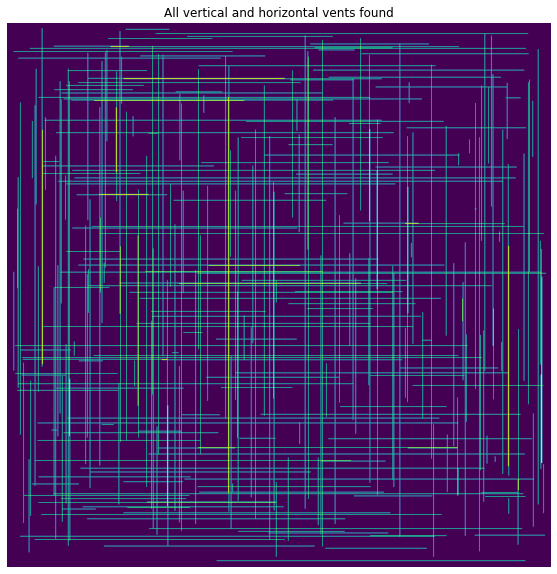

In [14]:
display[display == 0] = -100

plt.figure(figsize=[10,10])
plt.imshow(display)
plt.title("All vertical and horizontal vents found")
plt.axis(False)
plt.show()

In [15]:
dangerous_vents = (display > 1).sum()
print(f"There are {dangerous_vents} dangerous vents in your area")

There are 5306 dangerous vents in your area


# Part Two

Unfortunately, considering only horizontal and vertical lines doesn't give you the full picture; you need to also consider diagonal lines.

Because of the limits of the hydrothermal vent mapping system, the lines in your list will only ever be horizontal, vertical, or a diagonal line at exactly 45 degrees. In other words:

- An entry like 1,1 -> 3,3 covers points 1,1, 2,2, and 3,3.
- An entry like 9,7 -> 7,9 covers points 9,7, 8,8, and 7,9.

Considering all lines from the above example would now produce the following diagram:

```
1.1....11.
.111...2..
..2.1.111.
...1.2.2..
.112313211
...1.2....
..1...1...
.1.....1..
1.......1.
222111....
```

You still need to determine the number of points where at least two lines overlap. In the above example, this is still anywhere in the diagram with a 2 or larger - now a total of 12 points.

Consider all of the lines. At how many points do at least two lines overlap?

In [16]:
display = np.zeros((xmax + xmin, ymax + ymin))
for line in lines:
    display[line[:, 0], line[:, 1]] += 1

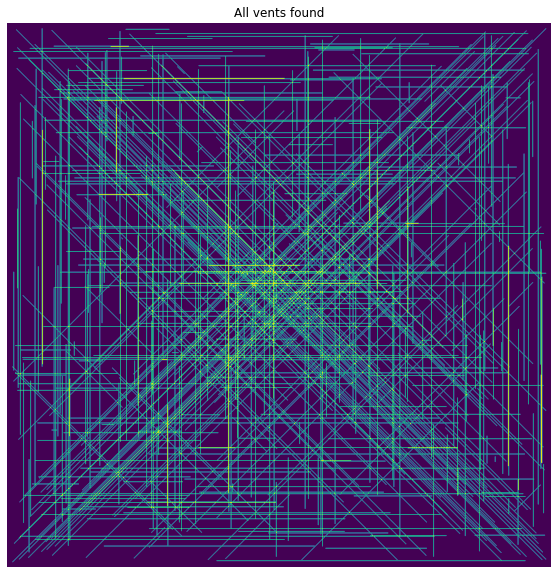

In [17]:
display[display == 0] = -100

plt.figure(figsize=[10,10])
plt.imshow(display)
plt.title("All vents found")
plt.axis(False)
plt.show()

In [18]:
dangerous_vents = (display > 1).sum()
print(f"There are {dangerous_vents} dangerous vents in your area")

There are 17787 dangerous vents in your area
